In [1]:
import numpy as np
import dill
import pandas as pd
from scipy import optimize as opt
import time
import sys
sys.path.append('../../')
import src


#Load policy and value function
#####################
file_n = "2018-10-5vfi_dict.dill"
with open('../../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)


In [2]:


# Simulation parameters \
########################
σerror= 0.005 #0.01
Nfirms = 300
time_periods = 40
min_periods= 3

#Suitable for logistic
β10, β11 = -2., 3.
β20, β21 = 0.03, -2.
betas = [β10, β11, β20, β21]

#GMM parameters
maxiters = 3


#def lambda_0(x, prior_shock) -> np.ndarray:
#    """
#    Generate a vector of lambdas on the observables x
#    """
#    return src.from_theta_to_lambda0(x, θ=betas, prior_shock=prior_shock)


xs = np.abs(np.random.normal(0, 0.18, size=Nfirms))
prior_shocks = src.gen_prior_shocks(Nfirms, σerror=σerror)

dmd_shocks = src.generate_dmd_shocks(n=Nfirms, t=time_periods, dmd_σϵ=src.const.σ_ɛ)

In [21]:
from scipy import optimize
from src import logit, jac, fun, force_sum_to_1, reparam_lambdas

def jac_(x):
    return jac(x, βs=src.betas_transition)



def from_theta_to_lambda0(x, θ, prior_shock, starting_values=np.array([0.1, 0.5])):
    """
    Generates a lambda0 vector from the theta vector and x
    It passes through the entropy and expected value of betas (H, EB)

    θ = [θ10, θ11, θ20, θ21]
    x : characteristics of firms
    prior_shock: puts randomness in the relationship between theta and lambda
    """
    #TODO: bound H between 0 and log(cardinality(lambdas))
    H = np.e**((θ[0] + θ[1]*x + prior_shock))
    Eβ = -np.e**(θ[2] + θ[3]*x + prior_shock) #Bound it?

    def fun_(x):
        return fun(x, src.betas_transition, Eβ, H)

    #Numerical procedure to get lambda vector from H, Eβ
    sol = optimize.root(fun_, logit(starting_values), jac=jac_)

    lambdas_sol = force_sum_to_1(reparam_lambdas(sol.x))

    return lambdas_sol

../../src/from_parameters_to_lambdas.py:8: RuntimeWarning: invalid value encountered in log
  return -np.sum(p * np.log(p))


array([0.1, 0.5, 0.4])

In [24]:
θ = np.array([-2., 3., 0.03, -2.]) 
x = 0.2
prior_shock = prior_shocks[4]

H = np.e**((θ[0] + θ[1]*x + prior_shock))
Eβ = -np.e**(θ[2] + θ[3]*x + prior_shock)

H, Eβ

(0.2785533259383541, -0.7802462044277202)

In [25]:
src.betas_transition

array([-4. , -1.7, -1.2])

In [31]:
matplotlib.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

Text(0.5,1,'Eβ')

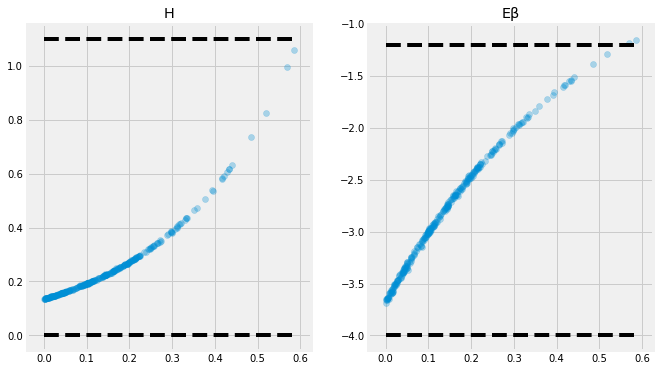

In [50]:
import matplotlib
matplotlib.style.use('fivethirtyeight')
#Scatter plot of H, EB as function of x and prior_shocks

%matplotlib inline
import matplotlib.pyplot as plt

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6))
θ = np.array([-2, 3.5, 1.3, -2.]) 

H = np.e**((θ[0] + θ[1]*xs + prior_shocks))
Eβ = -np.e**(θ[2] + θ[3]*xs + prior_shocks)
ax1.scatter(xs, H, alpha=0.3)
ax1.set_title("H")
ax1.hlines(0., xs.min(), xs.max(), linestyles="dashed")
ax1.hlines(np.log(3), xs.min(), xs.max(), linestyles="dashed")
ax2.scatter(xs, Eβ, alpha=0.3)
ax2.hlines(src.betas_transition.min(), xs.min(), xs.max(), linestyles="dashed")
ax2.hlines(src.betas_transition.max(), xs.min(), xs.max(), linestyles="dashed")
ax2.set_title("Eβ")


In [61]:
θ = np.array([-2, 3.5, 1.3, -2.]) 
θ_ = θ + 0.1
from_theta_to_lambda0(0.3, θ=θ_, prior_shock=prior_shocks[3])

../../src/from_parameters_to_lambdas.py:8: RuntimeWarning: invalid value encountered in log
  return -np.sum(p * np.log(p))


array([0.1, 0.5, 0.4])

In [43]:
src.betas_transition

array([-4. , -1.7, -1.2])

In [38]:
def my_entropy(p):
    return -np.sum(p * np.log(p))

In [46]:
my_entropy([1. - 0.00001, 0.00001, 0.00001])

0.0002402584592991924